# Ejercicio Ciudades

El presente notebook presenta el analisis del desafio de ciudades. El tiempo es de 3 horas. A continuación se presentan el proceso de los resultados. Este notebook es reproducible en binder usando el link del repositorio.



El objetivo es determinar si los estados de la costa este tienen más o menos ciudades que comparten nombre con el Reino Unido (UK), para ello se dispone de una base de datos pública.

Intentaré explicar paso a paso lo que voy haciendo incluyendo analisis exploratorios, etc.

In [38]:
import datetime as dt
import pandas as pd
import geopandas as gpd
import numpy as np
import json
import matplotlib.pyplot as plt


In [2]:
ti=dt.datetime.now() # tiempo inicial

En primer lugar abrimos la base de datos y realizamos un poco de exploración

Una vez importados los datos a formato geopandas (que servirán para graficar el resultado), usamos pandas para importar los datos como tabla.

In [3]:
url = "https://public.opendatasoft.com/explore/dataset/worldcitiespop/download/?format=csv&disjunctive.country=true&refine.country=us&refine.country=gb&timezone=America/Santiago&lang=en&use_labels_for_header=true&csv_separator=%3B"
df = pd.read_csv(url,sep=';')


In [4]:
df.head()

,Country,City,AccentCity,Region,Population,Latitude,Longitude,geopoint
0,us,lost creek,Lost Creek,KY,NaN,37.481667,-83.325278,"37.4816667,-83.3252778"
1,us,edgewood village,Edgewood Village,LA,NaN,32.400556,-93.842500,"32.4005556,-93.8425"
2,us,trout dale,Trout Dale,VA,NaN,36.701944,-81.440556,"36.7019444,-81.4405556"
3,us,trivoli,Trivoli,IL,NaN,40.690556,-89.891944,"40.6905556,-89.8919444"
4,us,barhamsville,Barhamsville,VA,NaN,37.454444,-76.840556,"37.4544444,-76.8405556"


Una ves cargada ambas bases de datos nos hace falta una pieza de información más: Qué estados se consideran parte de cada costa. Usando google. [https://en.wikipedia.org/wiki/East_Coast_of_the_United_States#:~:text=The%2014%20states%20that%20have,Carolina%2C%20Georgia%2C%20and%20Florida.]

Usando esto tenemos el listado de la costa este: **Maine, New Hampshire, Massachusetts, Rhode Island, Connecticut, New York, New Jersey, Delaware, Maryland, Virginia, North Carolina, South Carolina, Georgia, y Florida.** Es importante convertir esto a los codigos de 2 letras para poder filtrar luego.

[https://en.wikipedia.org/wiki/West_Coast_of_the_United_States] nos indica que generalmente se consideran **California, Oregon, Washington, y Alaska**

In [5]:
#creamos una lista con las costas, por sus codigos segun https://www.infoplease.com/us/postal-information/state-abbreviations-and-state-postal-codes
ec=['ME','NH','MA','RI','CT','NY','NJ','DE','MD','VA','NC','SC','GA','FL']
wc=['CA','OR','WA','AK']
# procedemos a filtrar la lista para incluir solo ciudades en cada área.
cec=df.loc[(df['Region'].isin(ec)) & (df['Country']=='us')]
cwc=df.loc[(df['Region'].isin(wc)) & (df['Country']=='us')]

# finalmente recuperamos los nombres de ciudades del reino unido para comparar
uk=df.loc[df['Country']=='gb','City']
uk.head()

197            yate
198          weston
200    stokenchurch
219        ramsgate
220       rhosneigr
Name: City, dtype: object

Antes de realizar la comparación y contar el numero de ciudades, me parece que aquelas ciudades de EEUU que tengan el prefijo "new" debiesen contar. Creo que el nombre "New" York esta claramente asociado a la ciudad de "York", por lo que antes de realizar las comparaciones, quitaré todos los prefijos "new " de los nombres de las ciudades. Es importante considerar el espacio antes para evitar cambiar el nombre de ciudades como "newark"



In [6]:
cwc["City2"]=None
cec["City2"]=None
cec["City2"]=cec.City.str.replace("new ","")
cwc["City2"]=cwc.City.str.replace("new ","")

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

Procedemos a buscar cuantas ciudades de la costa este y oeste estan en ambos casos.

In [7]:
matche=cec[cec["City2"].isin(uk.values)]
matchw=cwc[cwc["City2"].isin(uk.values)]
print(len(matche))
print(len(matchw))
matche.head()

2819
581


,Country,City,AccentCity,Region,Population,Latitude,Longitude,geopoint,City2
72,us,hill,Hill,NH,NaN,43.524167,-71.701389,"43.5241667,-71.7013889",hill
140,us,coldstream,Coldstream,GA,NaN,33.917222,-84.403889,"33.9172222,-84.4038889",coldstream
196,us,falkland,Falkland,NC,NaN,35.699167,-77.513333,"35.6991667,-77.5133333",falkland
260,us,beaufort,Beaufort,NJ,NaN,40.817778,-74.330000,"40.8177778,-74.33",beaufort
333,us,bingham,Bingham,ME,NaN,45.058611,-69.882778,"45.0586111,-69.8827778",bingham


Obtenidos los numeros absolutos,la respuesta es evidente, la costa este tiene 2819 ciudades con nombres derivados el reino unido, mientras que la costa oeste tiene 581. Ahora intentaremos representarlos de una forma más amigable. Para esto utilizaremos las capacidades interactivas de este notebook.

En primer lugar agruparemos por estado el numero de ciudades con nombre similares para nuestra base

In [18]:
neast=matche.groupby('Region')['City'].count().reset_index()
nwest=matchw.groupby('Region')['City'].count().reset_index()

In [9]:
url = "gz_2010_us_040_00_5m.shp"
geo = gpd.read_file(url)
geo.head()

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
0,0400000US01,01,Alabama,None,50645.326,"MULTIPOLYGON (((-88.12466 30.28364, -88.08681 ..."
1,0400000US02,02,Alaska,None,570640.950,"MULTIPOLYGON (((-166.10574 53.98861, -166.0752..."
2,0400000US04,04,Arizona,None,113594.084,"POLYGON ((-112.53859 37.00067, -112.53454 37.0..."
3,0400000US05,05,Arkansas,None,52035.477,"POLYGON ((-94.04296 33.01922, -94.04304 33.079..."
4,0400000US06,06,California,None,155779.220,"MULTIPOLYGON (((-122.42144 37.86997, -122.4213..."


El archivo que encontre con los estados lamentablemente tiene los nombres de los estados enteros, por lo que busque un diccionario que me permitiera transformar rapidamente de uno al otro.

In [12]:
states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [21]:
neast['llave']=neast.Region.map(states)
nwest['llave']=nwest.Region.map(states)
neast

,Region,City,llave
0,CT,103,Connecticut
1,DE,73,Delaware
2,FL,153,Florida
3,GA,291,Georgia
4,MA,221,Massachusetts
5,MD,310,Maryland
6,ME,135,Maine
7,NC,261,North Carolina
8,NH,135,New Hampshire
9,NJ,175,New Jersey


In [31]:

geo['nciudades']=geo.merge(pd.concat([neast,nwest])[['llave','City']],how='left',left_on='NAME',right_on='llave')['City']
geo['nciudades']=geo['nciudades'].fillna(0)

ImportError: The descartes package is required for plotting polygons in geopandas. You can install it using 'conda install -c conda-forge descartes' or 'pip install descartes'.

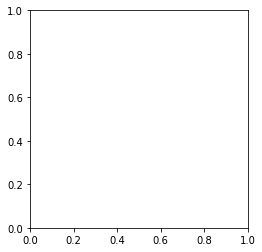

In [39]:
geo.plot()

In [ ]:
tf-ti

In [13]:
tf=dt.datetime.now() 


datetime.timedelta(seconds=24, microseconds=609288)